In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [3]:
# # 大庆市
# roi = ee.Geometry.Rectangle([123.9355, 45.8362,125.3055, 46.8762])
# # 天津市
# roi = ee.Geometry.Rectangle([115.9244, 38.6272,117.4944,39.6372])
# # 武汉市
roi = ee.Geometry.Rectangle([113.7393, 29.8642,115.0993, 30.9242])
# # 珠三角
# roi = ee.Geometry.Rectangle([112.7614, 22.2347,114.0514, 23.2547])
# 青藏高原
# roi = ee.Geometry.Rectangle([89.8826, 34.6579,91.3626, 35.8279])
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,7)

In [5]:
region = 'wuhan'
sample_region = 'WUHAN'

In [6]:
# 移除无效像元
elevation = ee.Image("users/311605001111/hillshade_" + region)
def maskSR(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = img.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    azimuth = img.get('SOLAR_AZIMUTH_ANGLE')
    zenith = img.get('SOLAR_ZENITH_ANGLE')
    image = img.lt(0)
    bands = image.select('B2').add(image.select('B3')).add(image.select('B4')).add(image.select('B5')).add(image.select('B6')).add(image.select('B7'))
    outlier = bands.gt(0).remap([0,1],[1,0]).rename('outlier')
    return img.updateMask(mask).updateMask(ee.Terrain.hillShadow(elevation,azimuth,zenith,200,True)).updateMask(outlier)

# 数据

In [9]:
l5 = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
       .select(['B1', 'B2', 'B3', 'B4', 'B5', 'B7','pixel_qa'],['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)        
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
       .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','pixel_qa']) \
       .filterBounds(roi)

visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

year = '2020'
startDate = str(year) + '-01-01'
endDate = str(year) + '-12-31'
refer_img = ee.ImageCollection(l8.merge(l5)).filterDate(startDate, endDate).map(maskSR).median().clip(roi)
Map.addLayer(refer_img, visParams,'refer_img')

# 范围

In [10]:
#### 设置年份
JRC_id = 'JRC/GSW1_3/YearlyHistory/' + year
Maryland_id = 'users/311605001111/MARYLAND/Maryland_nationwide_' + year
basemap = ee.Image.constant(0).clip(roi).rename('waterclass')
# JRC
JRC = ee.Image(JRC_id).clip(roi).remap([0,1,2,3],[0,0,1,2]).rename('waterclass')
JRC_waterclass = ee.ImageCollection([JRC,basemap]).sum()
# Maryland
Maryland = ee.Image(Maryland_id).clip(roi).select('b1').rename('waterclass')
Maryland_permanent = Maryland.select('waterclass').gte(75).remap([0,1],[0,2]).rename('waterclass')
Maryland_season= ee.ImageCollection([Maryland.gte(25),Maryland.lt(75)]).sum().eq(2)
Maryland_waterclass = ee.ImageCollection([Maryland_permanent,Maryland_season,basemap]).sum()
# 三者的交集
permanentWaterExtent = ee.ImageCollection([JRC_waterclass.eq(2),Maryland_waterclass.eq(2)]).sum().eq(2)
landExtent = ee.ImageCollection([JRC_waterclass.eq(0),Maryland_waterclass.eq(0)]).sum().eq(2)
seasonWaterExtent_min = ee.ImageCollection([JRC_waterclass.eq(1),Maryland_waterclass.eq(1)]).sum().eq(2)
seasonWaterExtent_max = ee.ImageCollection([permanentWaterExtent,landExtent]).sum().remap([0,1],[1,0]).rename('waterclass')

# 制图

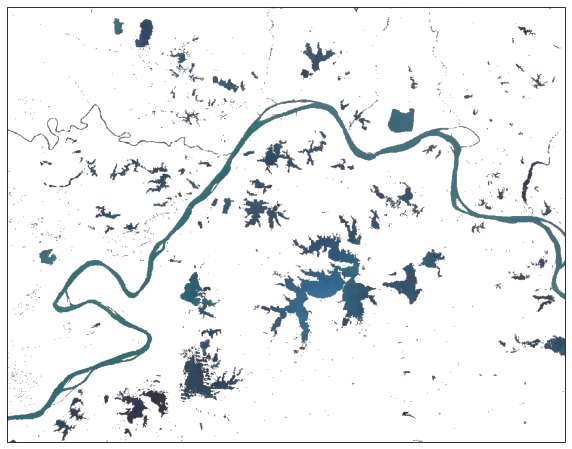

In [11]:
# PW
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

re = [115.0993, 29.8642, 113.7393, 30.9242]
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# use cartoee to get a map
ax = cartoee.get_map(refer_img.updateMask(permanentWaterExtent), region=re,vis_params=visParams)
# cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
# ax.set_title(label = 'reference image (20200819)', fontsize=24)

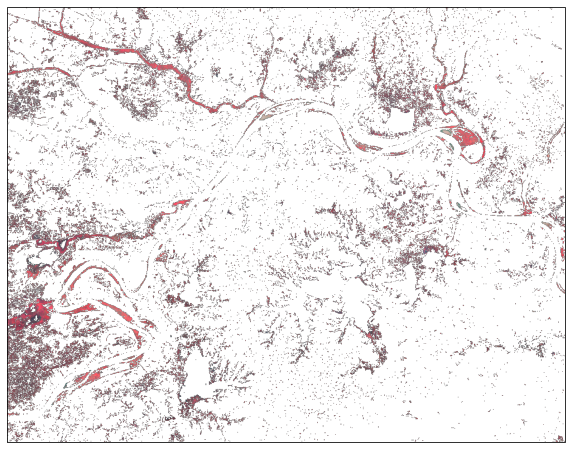

In [12]:
# SW--min
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

re = [115.0993, 29.8642, 113.7393, 30.9242]
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# use cartoee to get a map
ax = cartoee.get_map(refer_img.updateMask(seasonWaterExtent_min), region=re,vis_params=visParams)
# cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
# ax.set_title(label = 'reference image (20200819)', fontsize=24)

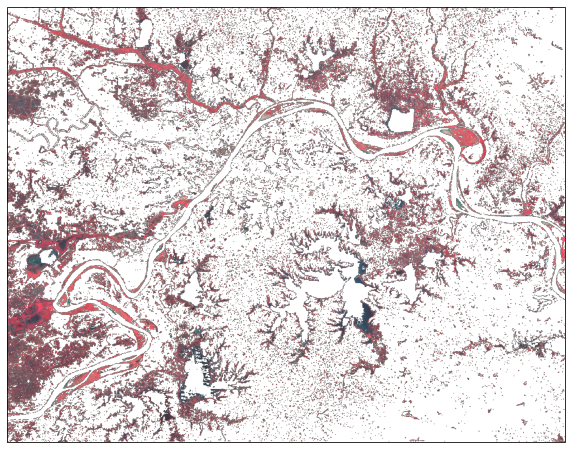

In [14]:
# SW--max
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

re = [115.0993, 29.8642, 113.7393, 30.9242]
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# use cartoee to get a map
ax = cartoee.get_map(refer_img.updateMask(seasonWaterExtent_max), region=re,vis_params=visParams)
# cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
# ax.set_title(label = 'reference image (20200819)', fontsize=24)

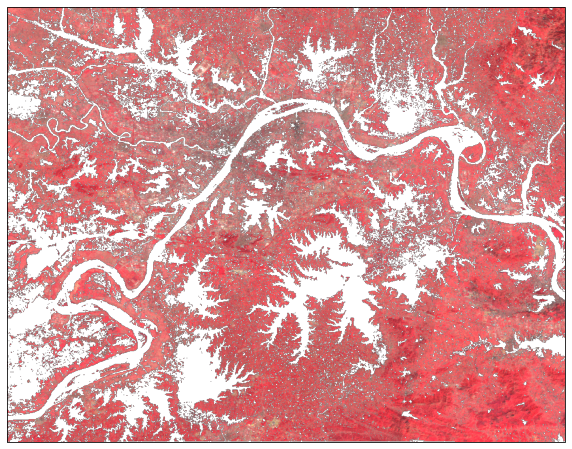

In [13]:
# NW
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee

re = [115.0993, 29.8642, 113.7393, 30.9242]
fig = plt.figure(figsize=(12, 8))
visParams = {'bands': ['B5', 'B4', 'B3'],'min': 0,'max': 3000,'gamma': 1.4}

# use cartoee to get a map
ax = cartoee.get_map(refer_img.updateMask(landExtent), region=re,vis_params=visParams)
# cartoee.add_gridlines(ax, interval=[0.3,0.3], linestyle=":")
# ax.set_title(label = 'reference image (20200819)', fontsize=24)